# Summarize models fit to natural populations

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize predictors](#Summarize-predictors)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted distances](#Summarize-observed-and-predicted-distances)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


## Define configuration settings
[back to top](#Summarize-models)

In [6]:
predictor_names_order = [
    "naive",
    "ep_x",
    "cTiter",
    "ne_star",
    "dms_star",
    "delta_frequency",
    "lbi",
    "ep_x-ne_star",
    "lbi-ep_x-ne_star"
]

In [64]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [65]:
sample = "natural_sample_0_with_10_vpm"

In [68]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == sample].copy()

In [70]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint,type,sample
0,naive,0.576160,57,2002-10-01,natural,natural_sample_0_with_10_vpm
1,naive,0.514613,47,2003-04-01,natural,natural_sample_0_with_10_vpm
2,naive,0.453460,66,2003-10-01,natural,natural_sample_0_with_10_vpm
3,naive,0.378223,81,2004-04-01,natural,natural_sample_0_with_10_vpm
4,naive,0.229502,72,2004-10-01,natural,natural_sample_0_with_10_vpm


In [ ]:
coefficients_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == sample].copy()

## Load data
[back to top](#Summarize-models)

In [8]:
tip_attributes_df = pd.read_table(data_root + "tip_attributes_with_weighted_distances.tsv", parse_dates=["timepoint"])

In [9]:
observed_weighted_distances = tip_attributes_df.loc[:, ["timepoint", "strain", "frequency", "weighted_distance_to_future"]].copy()

In [10]:
observed_weighted_distances["y"] = observed_weighted_distances["weighted_distance_to_future"]

In [11]:
model_jsons = glob.glob(data_root + "models_by_distances/*.json")

In [12]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [13]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [14]:
models_by_predictors["lbi"]["l1_lambda"]

0.01

In [15]:
models_by_predictors["lbi"]["training_window"]

6

In [16]:
models_by_predictors["lbi"]["pseudocount"]

In [17]:
type(models_by_predictors["lbi"])

dict

In [18]:
sorted(models_by_predictors.keys())

['cTiter',
 'delta_frequency',
 'dms_star',
 'ep_x',
 'ep_x-ne_star',
 'lbi',
 'lbi-ep_x-ne_star',
 'naive',
 'ne_star']

In [19]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'mean_stds_mean', 'mean_stds_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [20]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'mean_stds', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [21]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

268

In [22]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['y', 'y_hat'])

In [23]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[1.052251321281977]

In [24]:
models_by_predictors["lbi"]["scores"][0]["mean_stds"]

[0.1275747369503312]

In [25]:
len(models_by_predictors["lbi"]["scores"])

25

Build data frames for plotting from the model scores.

In [26]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
mean_stds_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": pd.to_datetime(scores["validation_timepoint"]),
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient, mean_std in zip(model["predictors"], scores["coefficients"], scores["mean_stds"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": pd.to_datetime(scores["validation_timepoint"])
            })
            
            mean_stds_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "mean_std": mean_std,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        #X = pd.DataFrame(scores["validation_data"]["X"])
        #X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])
        y["future_timepoint"] = pd.to_datetime(y["future_timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        #training_X = pd.DataFrame(scores["training_data"]["X"])
        #training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
mean_stds_by_time_df = pd.DataFrame(mean_stds_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [27]:
overall_errors_df.sort_values("cv_error_mean")

,cv_error_mean,cv_error_std,predictors
1,0.018555,0.248610,lbi
2,0.085244,0.232563,lbi-ep_x-ne_star
5,0.112806,0.181989,delta_frequency
0,0.174912,0.230039,dms_star
3,0.208895,0.292942,ne_star
8,0.241559,0.159610,naive
4,0.252660,0.273430,ep_x-ne_star
6,0.268414,0.272912,cTiter
7,0.285034,0.199574,ep_x


## Summarize predictors
[back to top](#Summarize-models)

In [28]:
individual_predictor_names_order = [
    predictor
    for predictor in predictor_names_order
    if not "-" in predictor and predictor != "naive"
]

In [29]:
individual_predictor_names_order

['ep_x', 'cTiter', 'ne_star', 'dms_star', 'delta_frequency', 'lbi']

In [30]:
long_predictors_df = tip_attributes_df.melt(
    id_vars=["strain", "timepoint"],
    value_vars=individual_predictor_names_order,
    var_name="predictor",
    value_name="predictor_value"
)

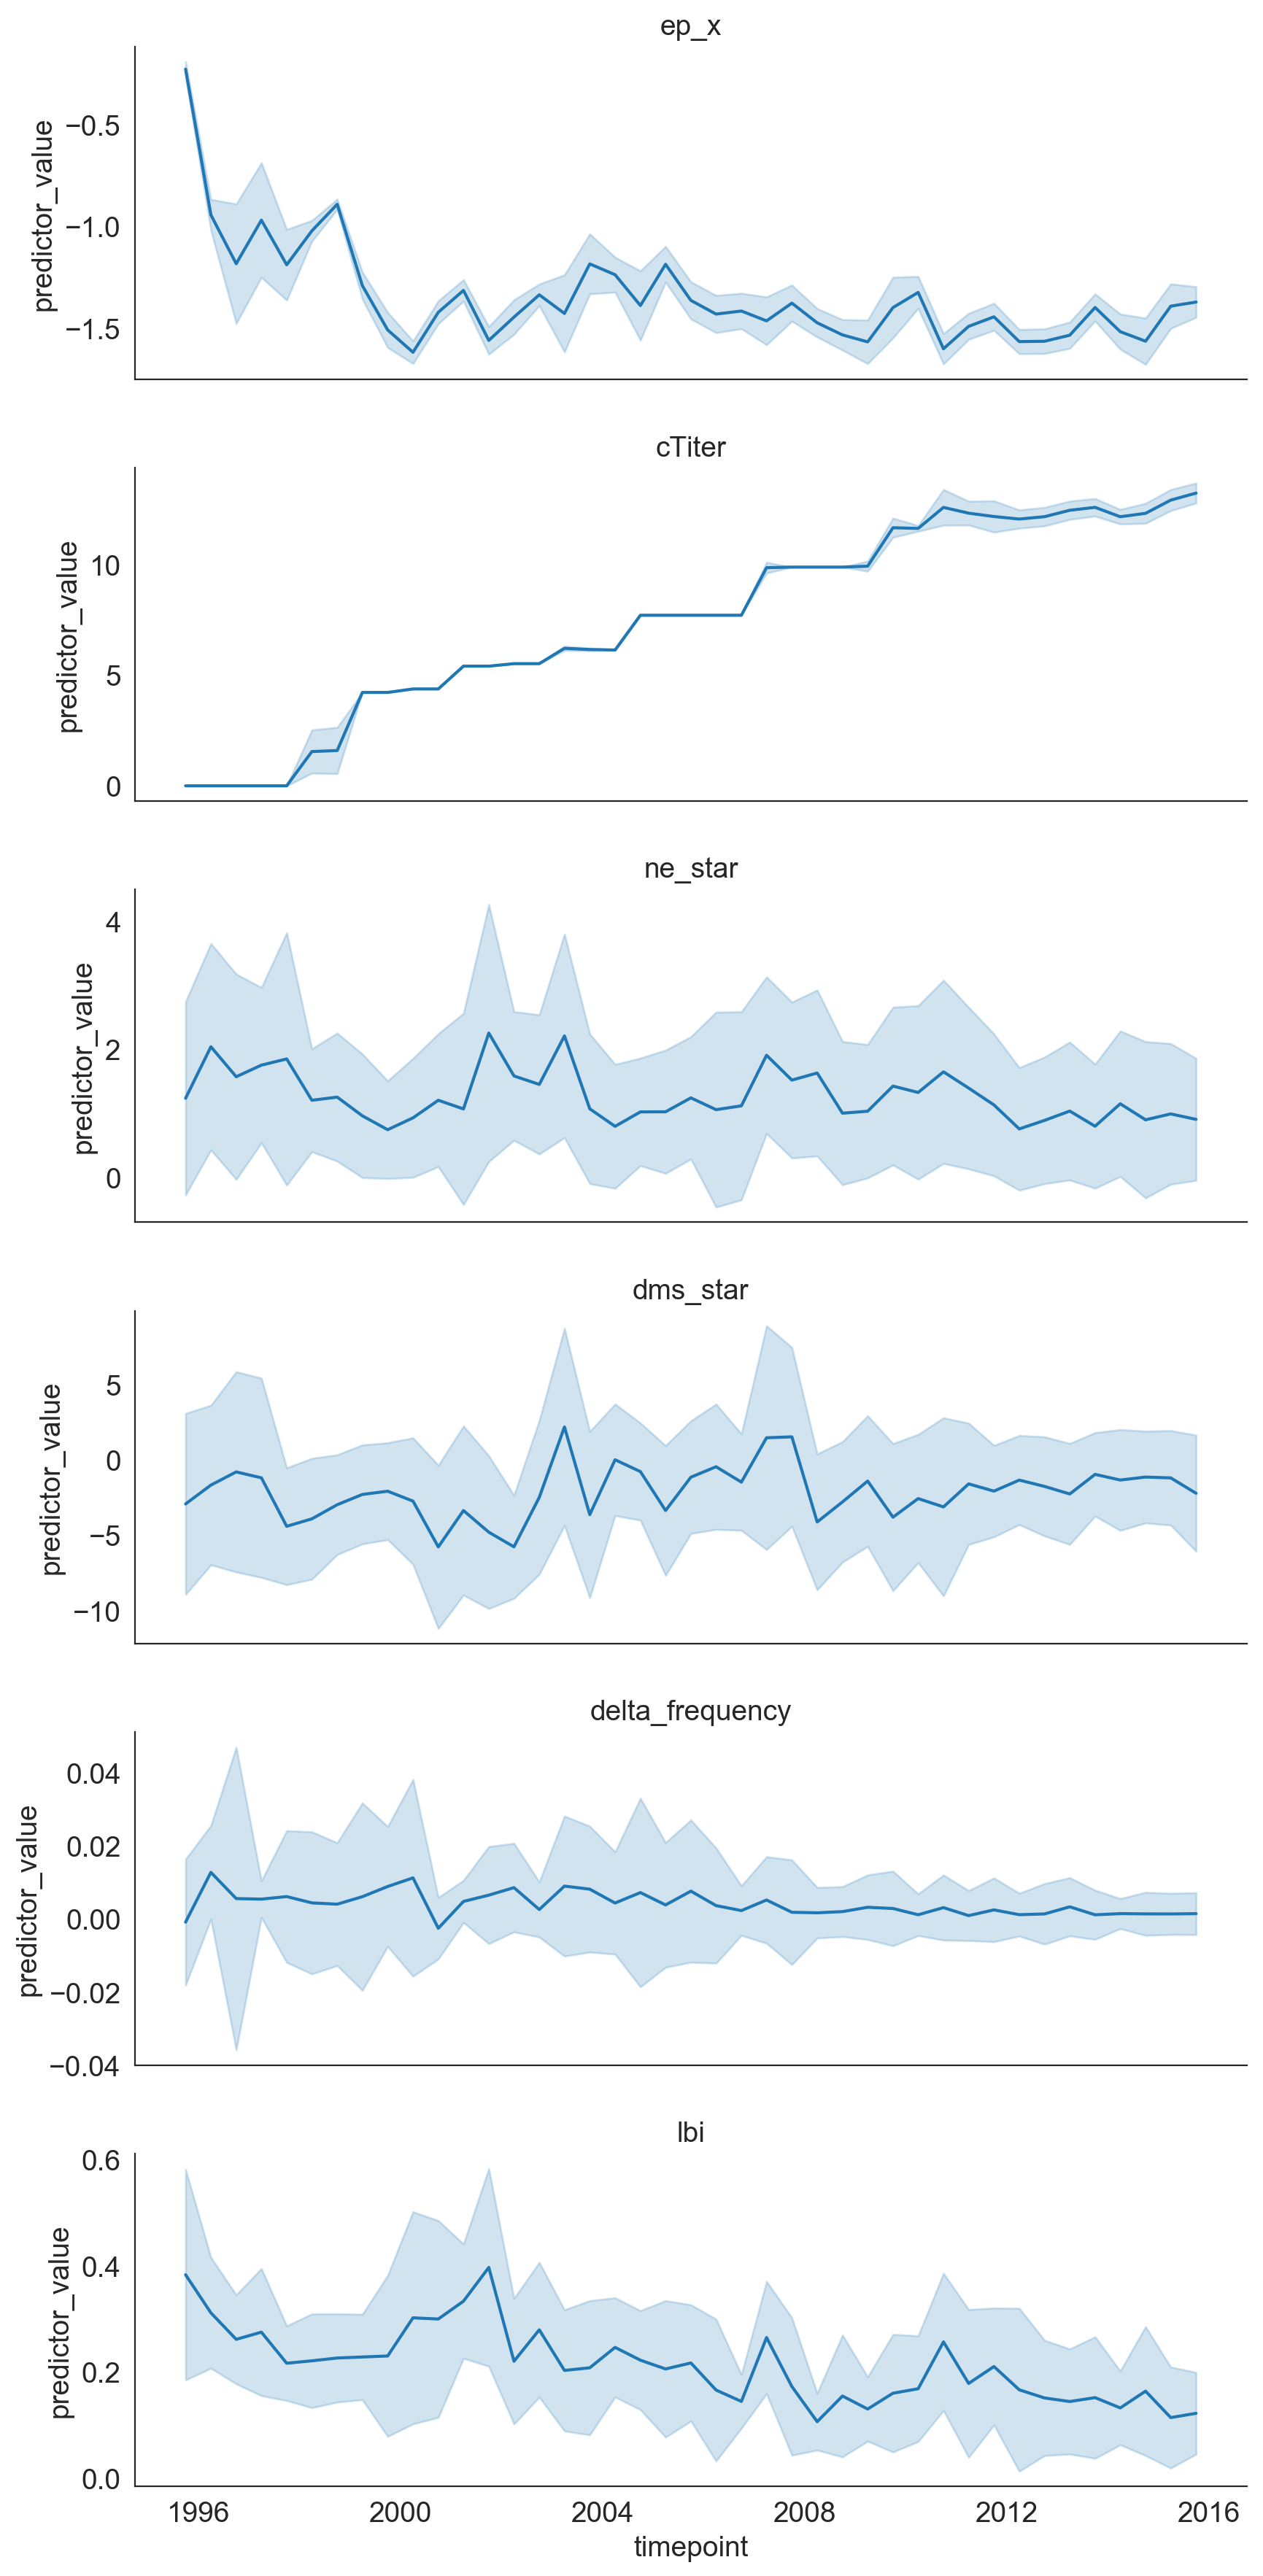

In [31]:
g = sns.FacetGrid(long_predictors_df, row="predictor", aspect=3, sharey=False,
                  row_order=individual_predictor_names_order)
g.map(sns.lineplot, "timepoint", "predictor_value", ci="sd")
g.set_titles("{row_name}")

plt.savefig("../manuscript/figures/predictors_by_timepoint.png")

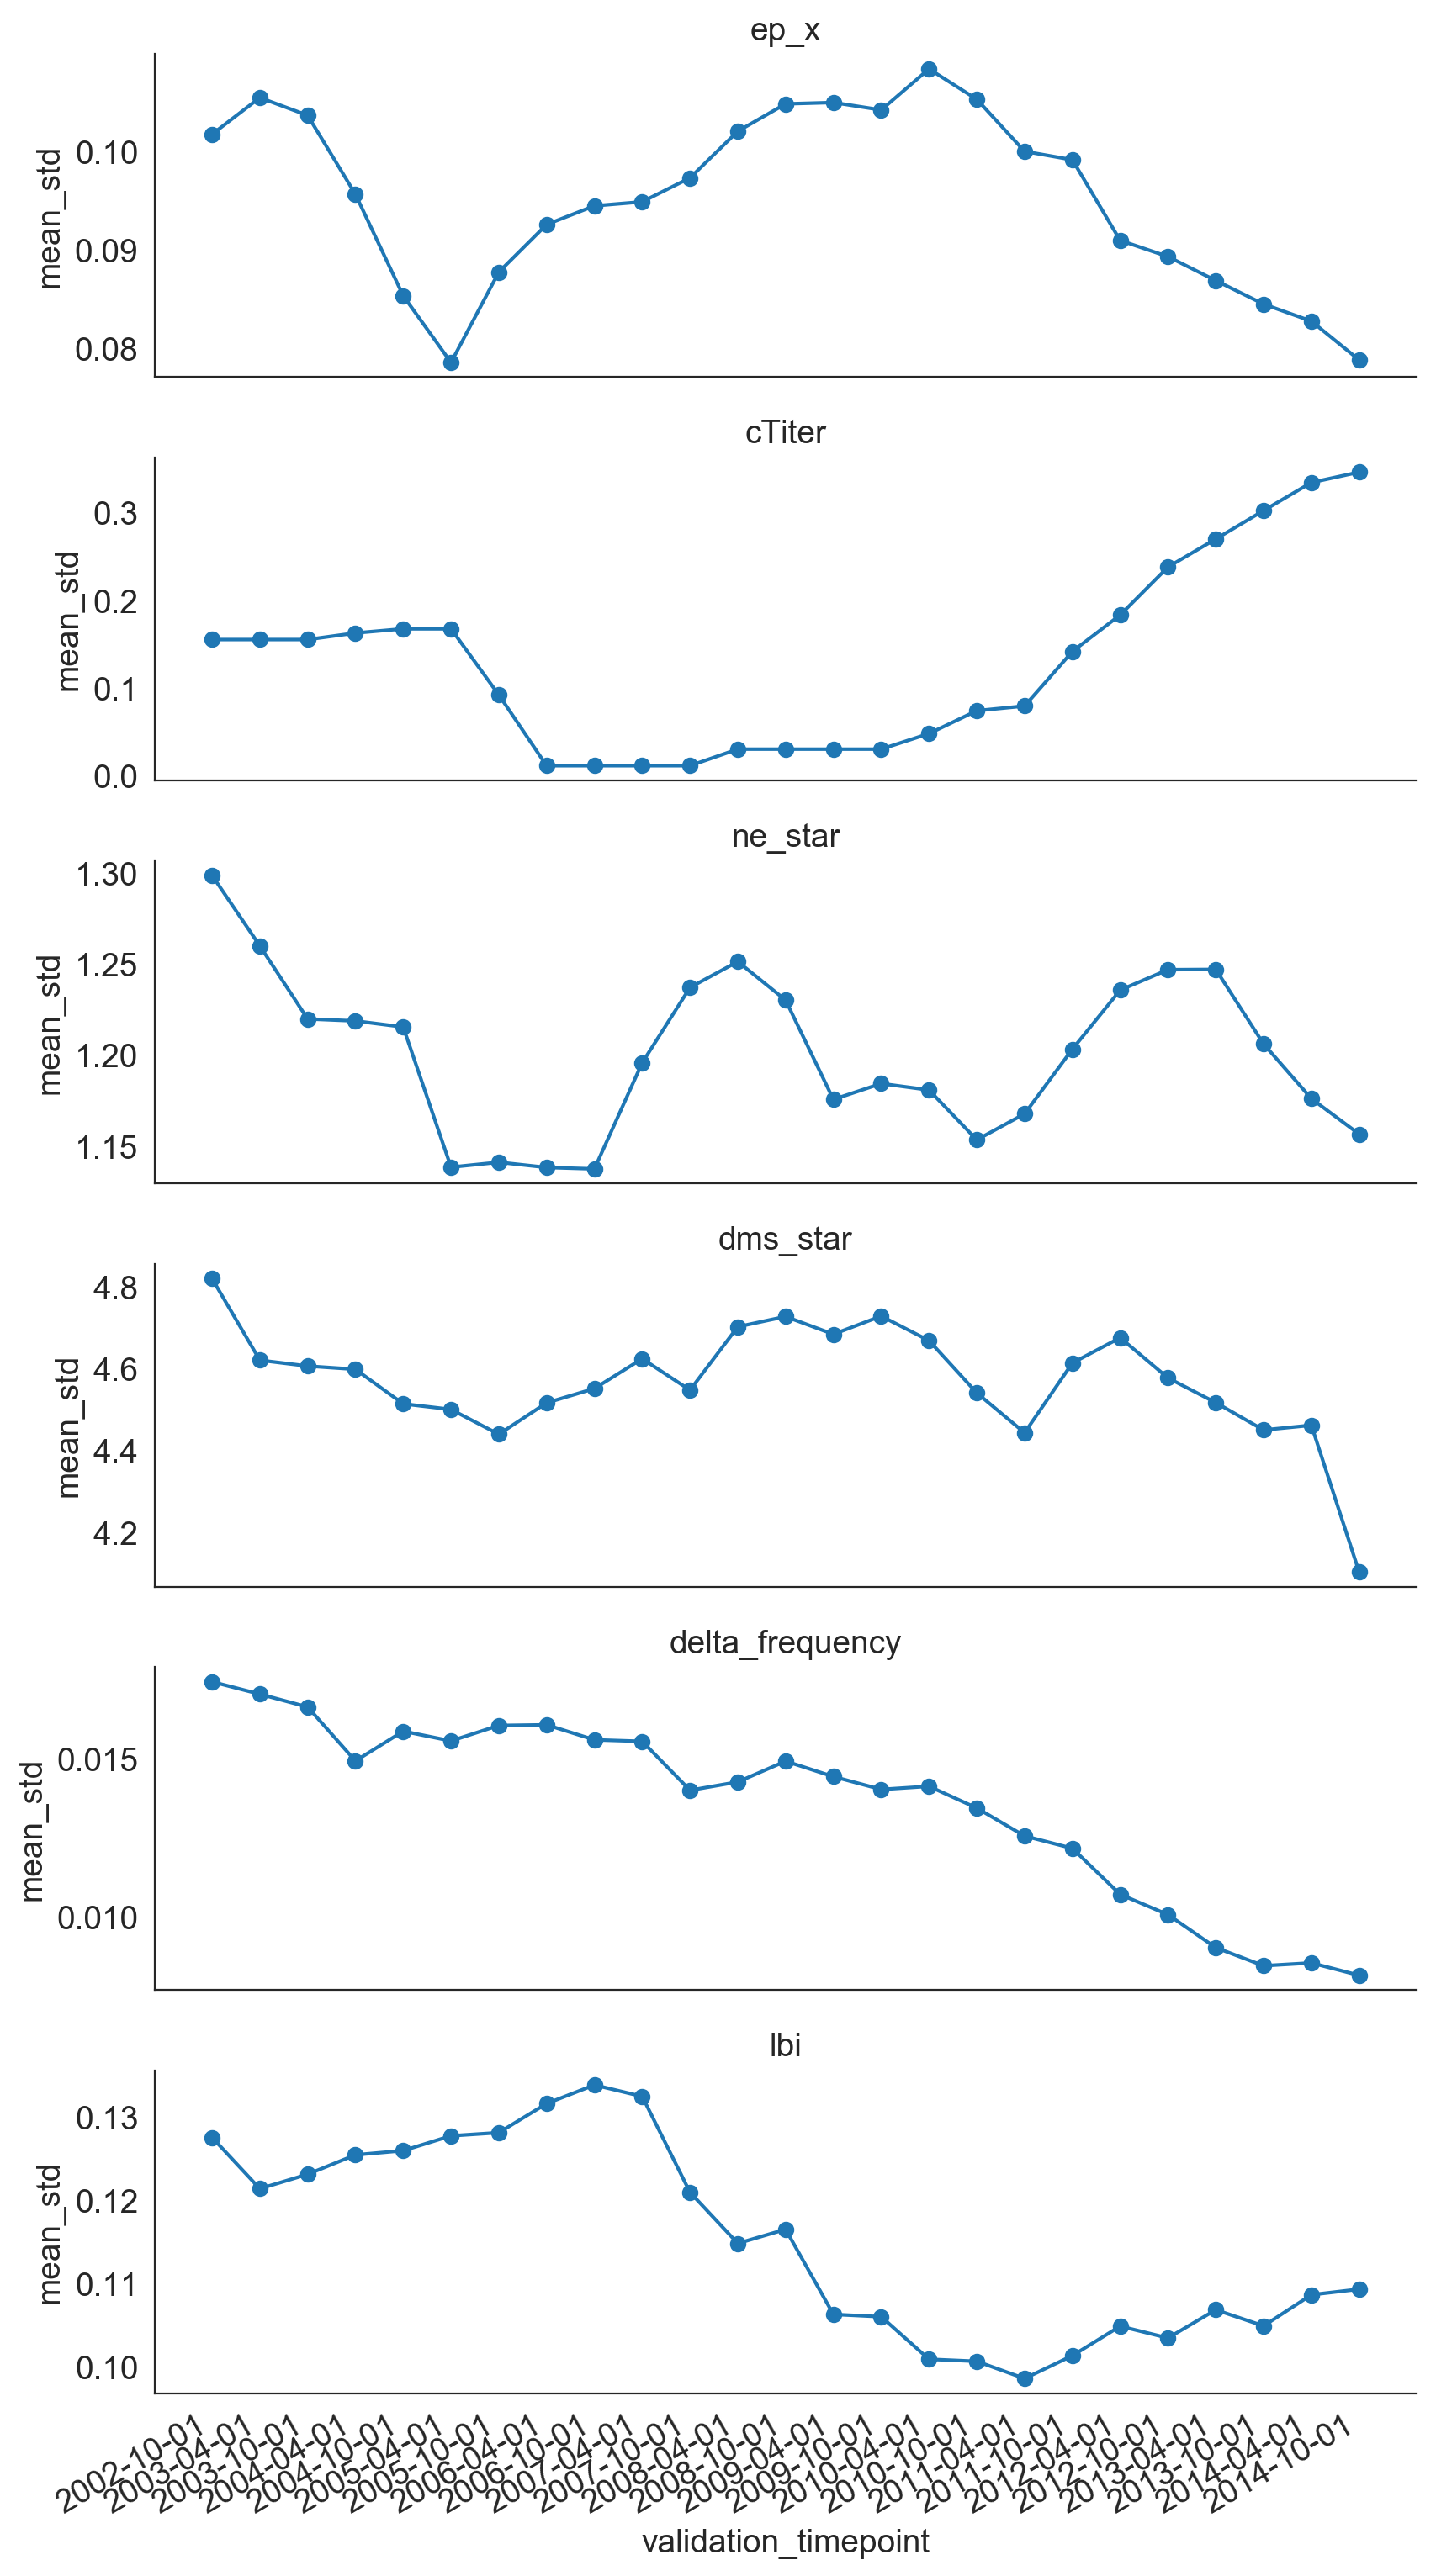

In [32]:
g = sns.FacetGrid(
    mean_stds_by_time_df[mean_stds_by_time_df["predictors"].isin(individual_predictor_names_order)],
    row="predictor",
    row_order=individual_predictor_names_order,
    aspect=3,
    sharey=False
)
g.map(plt.plot, "validation_timepoint", "mean_std", marker="o")
g.set_titles("{row_name}")

plt.gcf().autofmt_xdate()

## Summarize observed and predicted distances
[back to top](#Summarize-models)

$$
d_{i}(x(t)) = \sum_{j}x_{j}d_{ij}
$$

$$
u = t + \Delta{t}
$$

$$
\hat{x}_{i}(t, u) = x_{i}(t)e^{(f_{i}(t)(u - t))}
$$

$$
y = x_{i}(t)d_{i}(x(u))
$$

$$
\hat{y} = x_{i}(t)d_{i}(\hat{x}(t, u))
$$

$$
D(x(t), x(u)) = \sum_{i}x_{i}d_{i}(u)
$$

$$
D(\hat{x}(t, u), x(u)) = \sum_{i}x_{i}e^{(f_{i}(t)(u - t))}d_{i}(u)
$$

$$
L = \sum_{t}D(\hat{x}(t, u), x(u))
$$

In [33]:
frequency_df["observed_rank"] = frequency_df["y"] # / frequency_df["frequency"]
frequency_df["estimated_rank"] = frequency_df["y_hat"] # / frequency_df["frequency"]

In [34]:
regressions = []
for predictors, group_df in frequency_df.groupby(["predictors"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions.append({
        "predictors": predictors,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "r_2": r_value ** 2,
        "p_value": p_value
    })

regressions = pd.DataFrame(regressions).sort_values(by="r_2", ascending=False)

In [35]:
regressions

,intercept,p_value,predictors,r_2,r_value,slope
1,-0.250606,0.000000e+00,delta_frequency,0.558898,0.747595,0.747849
7,1.637927,0.000000e+00,naive,0.521201,0.721942,0.560432
0,1.294909,0.000000e+00,cTiter,0.468684,0.684605,0.658039
2,1.554750,0.000000e+00,dms_star,0.466943,0.683332,0.568995
5,-1.020141,0.000000e+00,lbi,0.419087,0.647370,0.697750
6,-0.720937,0.000000e+00,lbi-ep_x-ne_star,0.414709,0.643979,0.691094
3,2.328397,0.000000e+00,ep_x,0.400163,0.632584,0.512328
8,1.495546,0.000000e+00,ne_star,0.366678,0.605539,0.485302
4,2.257412,1.841452e-246,ep_x-ne_star,0.276221,0.525567,0.437136


In [36]:
regressions_order = regressions["predictors"].values

In [37]:
regressions_order

array(['delta_frequency', 'naive', 'cTiter', 'dms_star', 'lbi',
       'lbi-ep_x-ne_star', 'ep_x', 'ne_star', 'ep_x-ne_star'],
      dtype=object)

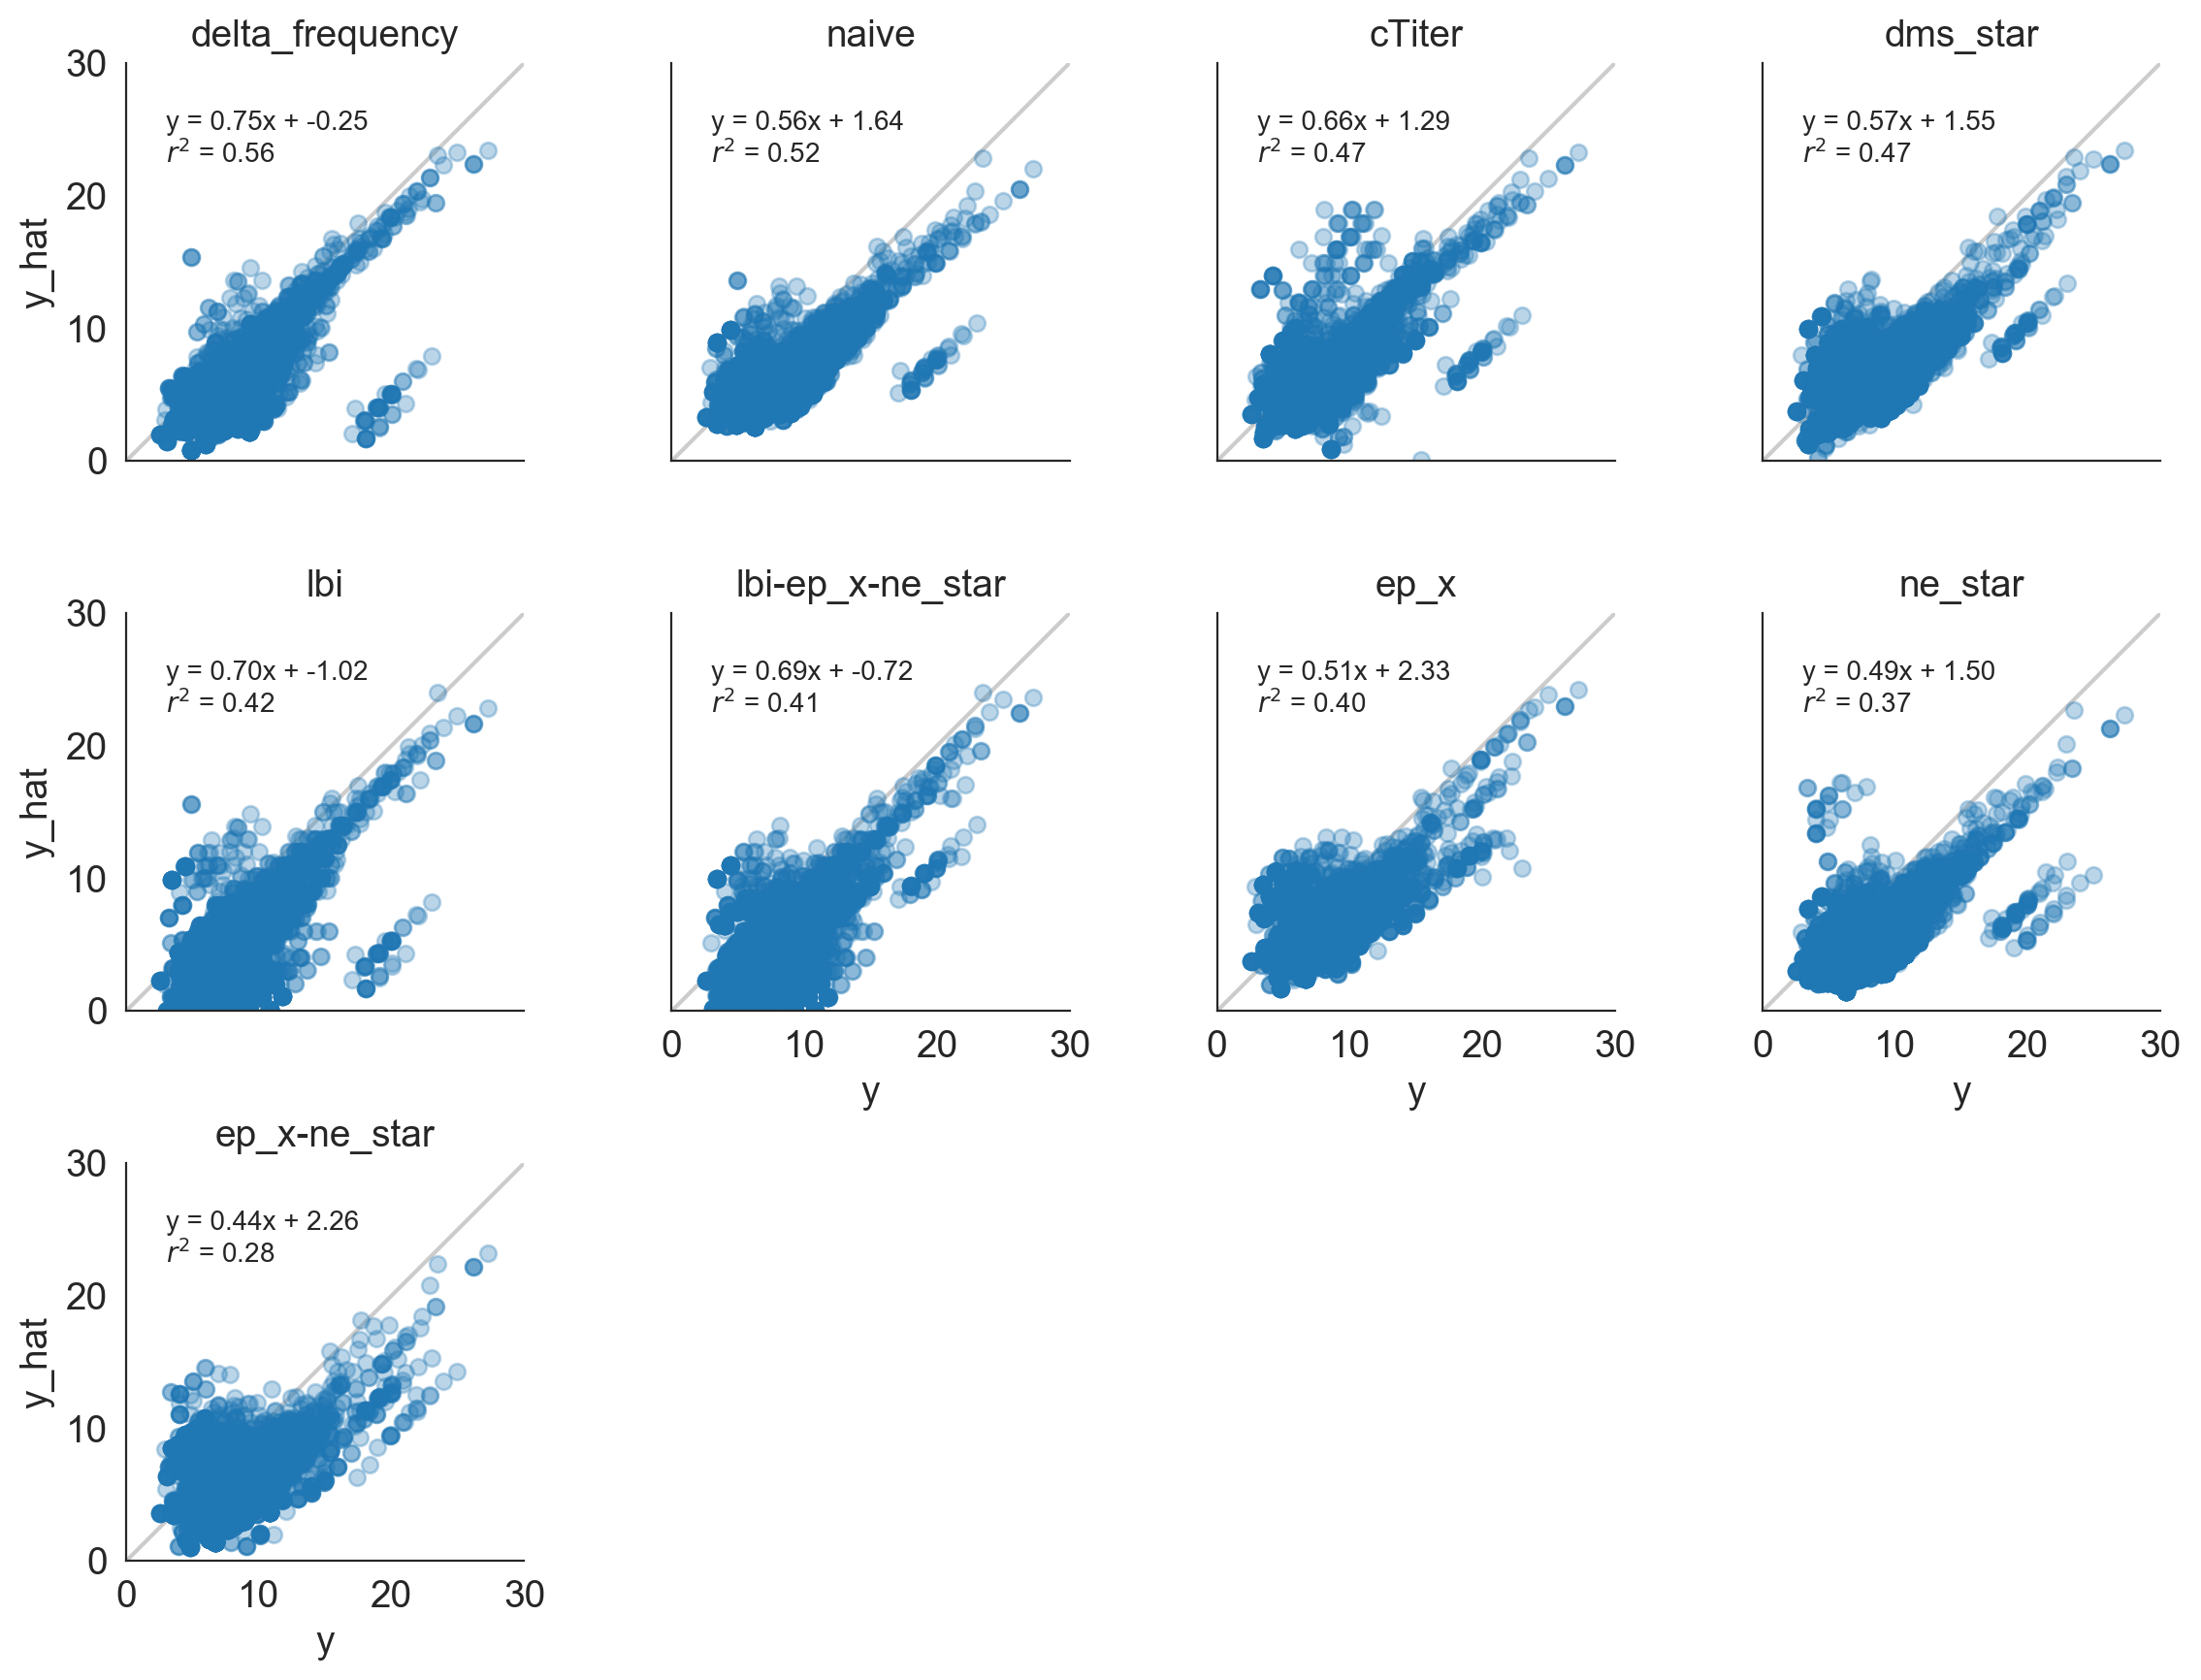

In [38]:
max_y = 30
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4, col_order=regressions_order)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value = regressions.loc[
        regressions["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)

Text(0.35,0.75,'mean = 8.66')

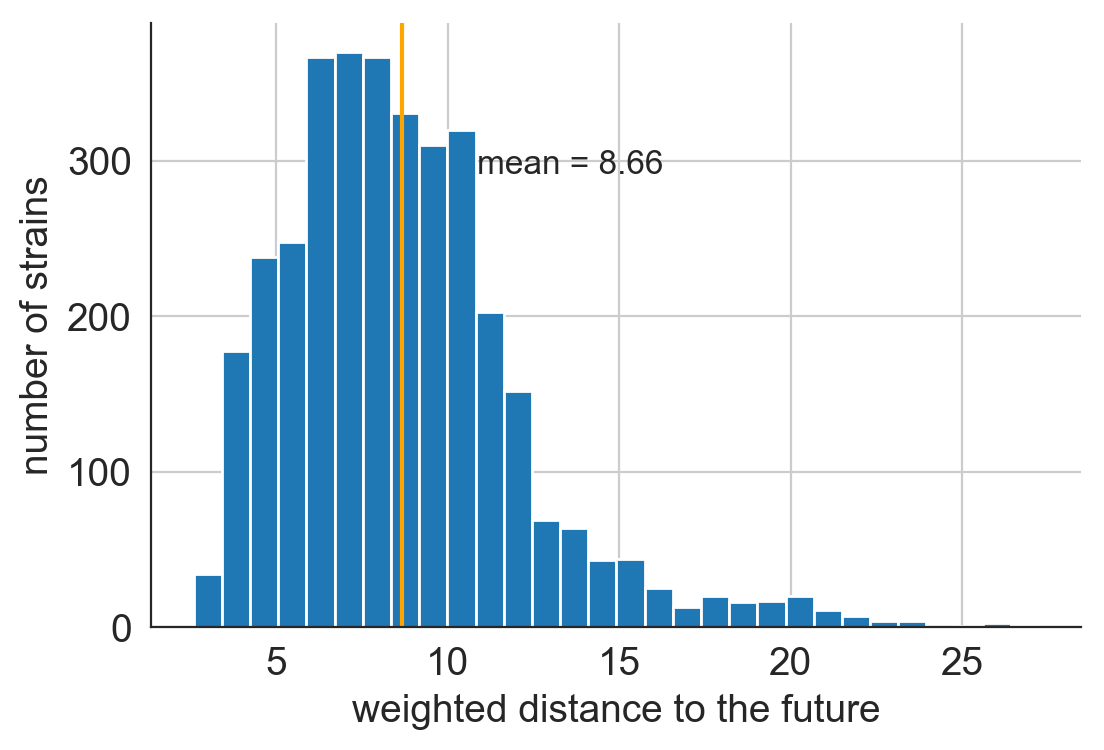

In [39]:
ax = frequency_df[frequency_df["predictors"] == "naive"]["y"].hist(bins=30)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of strains")

mean_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].mean()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.35,
    0.75,
    "mean = %.2f" % (mean_y,),
    transform=ax.transAxes,
    fontsize=12
)


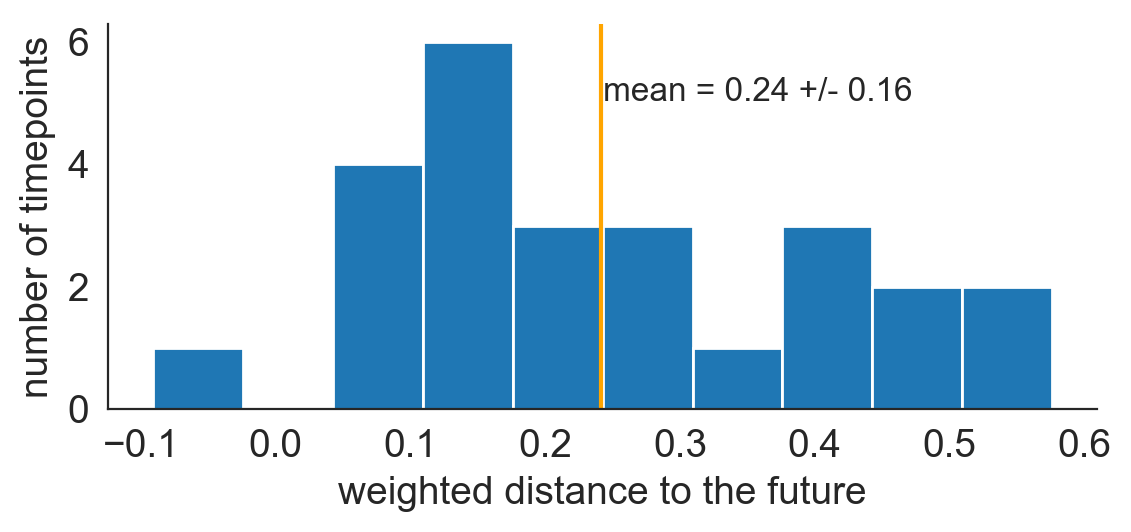

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"], bins=10)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].mean()
std_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

## Summarize model forecasting error
[back to top](#Summarize-models)

### Earth mover's distances

Training and validation errors are reported as [earth mover's distances](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). These values minimize the distance between observed and projected frequencies of tips at each timepoint with Hamming distance between amino acid sequences providing the ground distance between each pair of tips in respective timepoints.

In [41]:
distance_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [42]:
distance_df

,predictors,sum,mean,median
0,lbi,0.463865,0.018555,-0.048821
1,lbi-ep_x-ne_star,2.131105,0.085244,-0.004977
2,delta_frequency,2.820159,0.112806,0.082773
3,dms_star,4.372805,0.174912,0.142184
4,ne_star,5.222371,0.208895,0.212516
5,naive,6.038976,0.241559,0.200011
6,ep_x-ne_star,6.316493,0.252660,0.232807
7,cTiter,6.710344,0.268414,0.229502
8,ep_x,7.125853,0.285034,0.248664


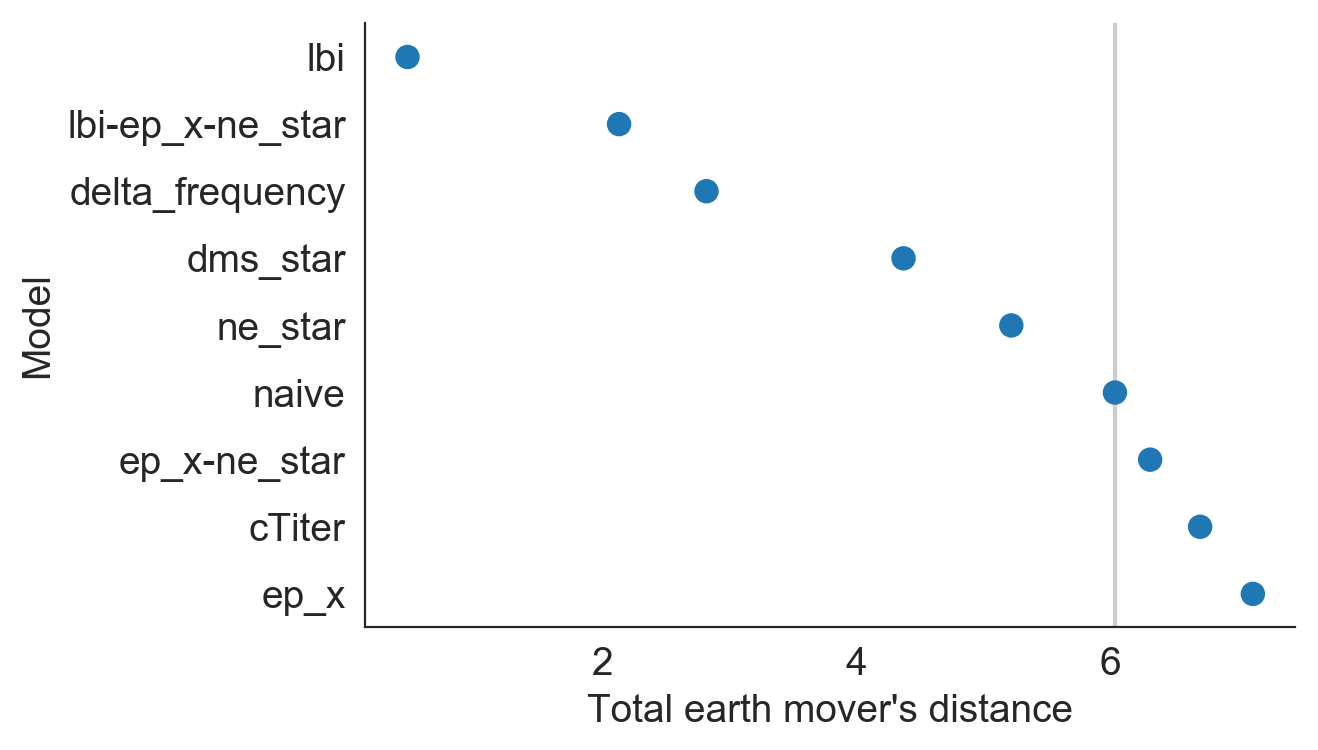

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.pointplot(
    x="sum",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Total earth mover's distance")
ax.set_ylabel("Model")
ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "sum"].values[0],
    color="#cccccc",
    zorder=-10
)

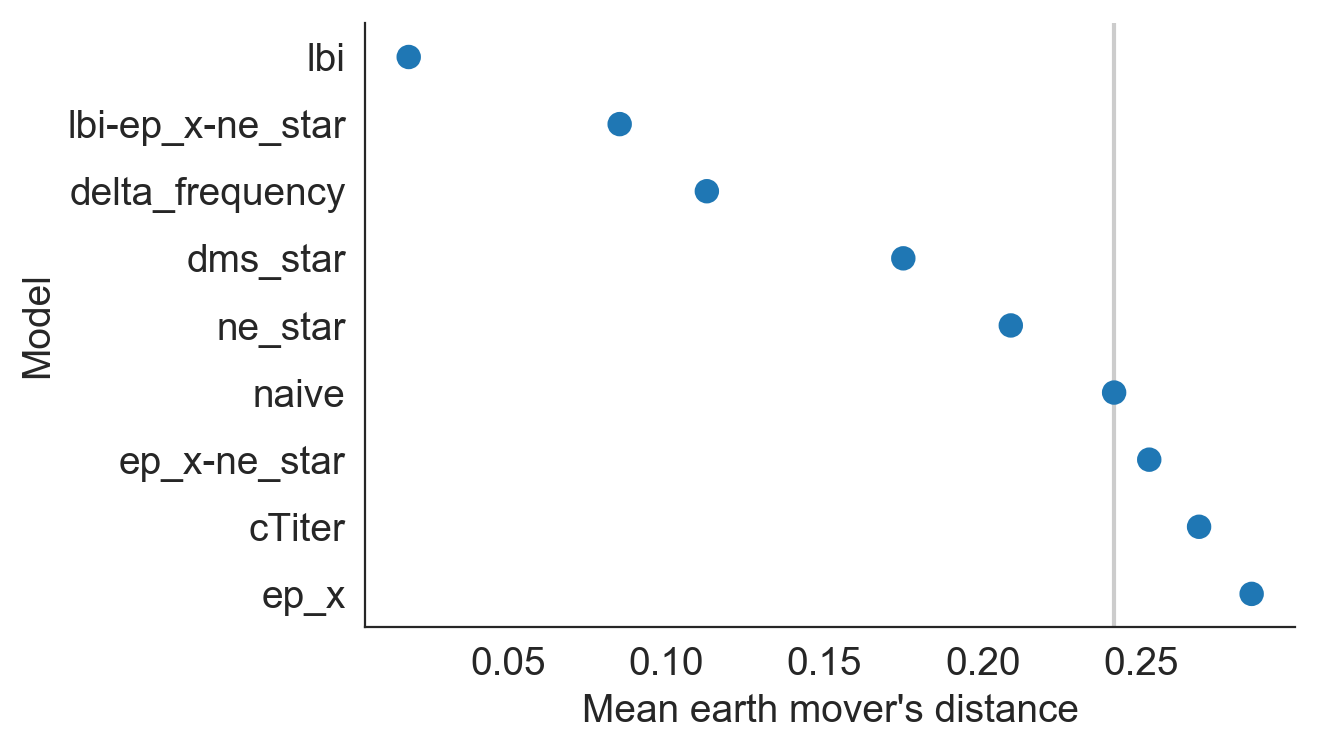

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.pointplot(
    x="mean",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Mean earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

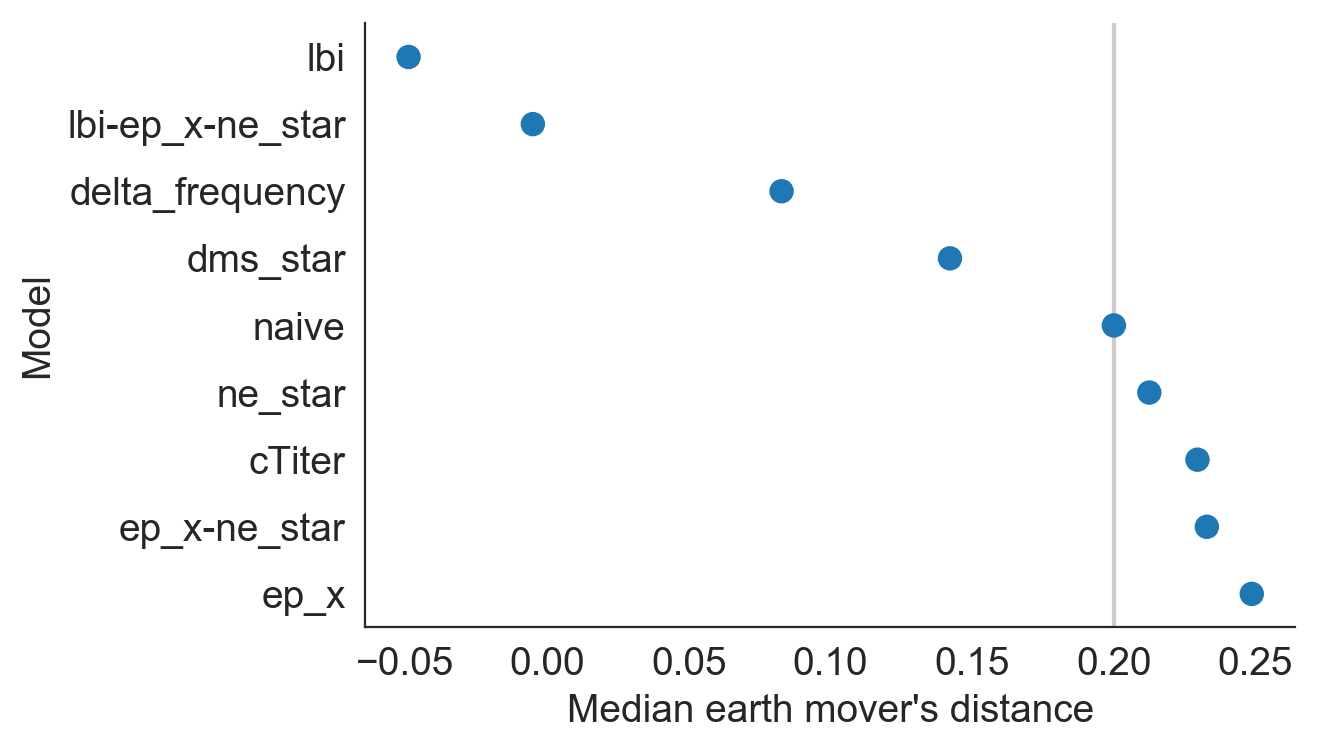

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Median earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

### Adjusted earth mover's distance (relative to naive model)

In [46]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    adjusted_error = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = adjusted_error

## Figure 3: Summary of models for natural populations

In [47]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [48]:
colors.reverse()

In [49]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [50]:
dict(zip(individual_predictor_names_order, colors))

{'ep_x': '#4575b4',
 'cTiter': '#91bfdb',
 'ne_star': '#e0f3f8',
 'dms_star': '#fee090',
 'delta_frequency': '#fc8d59',
 'lbi': '#d73027'}

In [51]:
nrows = len(individual_predictor_names_order)
ncols = 2
color_by_predictor = {
    'ep': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "ep": "epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "cross-immunity",
    "cTiter": "linear HI tree phenotypes",
    "cTiterSub": "linear HI mutation phenotypes",
    "cTiterSub_star": "ancestral HI mutation phenotypes",
    "cTiterSub_x": "HI phenotypes",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS phenotypes",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

In [52]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint,adjusted_error
0,dms_star,0.368759,57,2002-10-01,-0.207401
1,dms_star,0.088138,47,2003-04-01,-0.426475
2,dms_star,0.318535,66,2003-10-01,-0.134926
3,dms_star,0.670658,81,2004-04-01,0.292434
4,dms_star,0.027266,72,2004-10-01,-0.202237


In [53]:
min_error = errors_by_time_df["adjusted_error"].min()
max_error = errors_by_time_df["adjusted_error"].max()

min_normal_error = errors_by_time_df["validation_error"].min()
max_normal_error = errors_by_time_df["validation_error"].max()

min_coefficient = coefficients_by_time_df["coefficient"].min()
max_coefficient = coefficients_by_time_df["coefficient"].max()

min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)

In [54]:
individual_predictor_names_order

['ep_x', 'cTiter', 'ne_star', 'dms_star', 'delta_frequency', 'lbi']

In [55]:
individual_predictor_names_order = [
    'ep_x',
    "cTiter",
    'ne_star',
    'dms_star',
    'delta_frequency',
    'lbi'
]

In [56]:
nrows = len(individual_predictor_names_order)

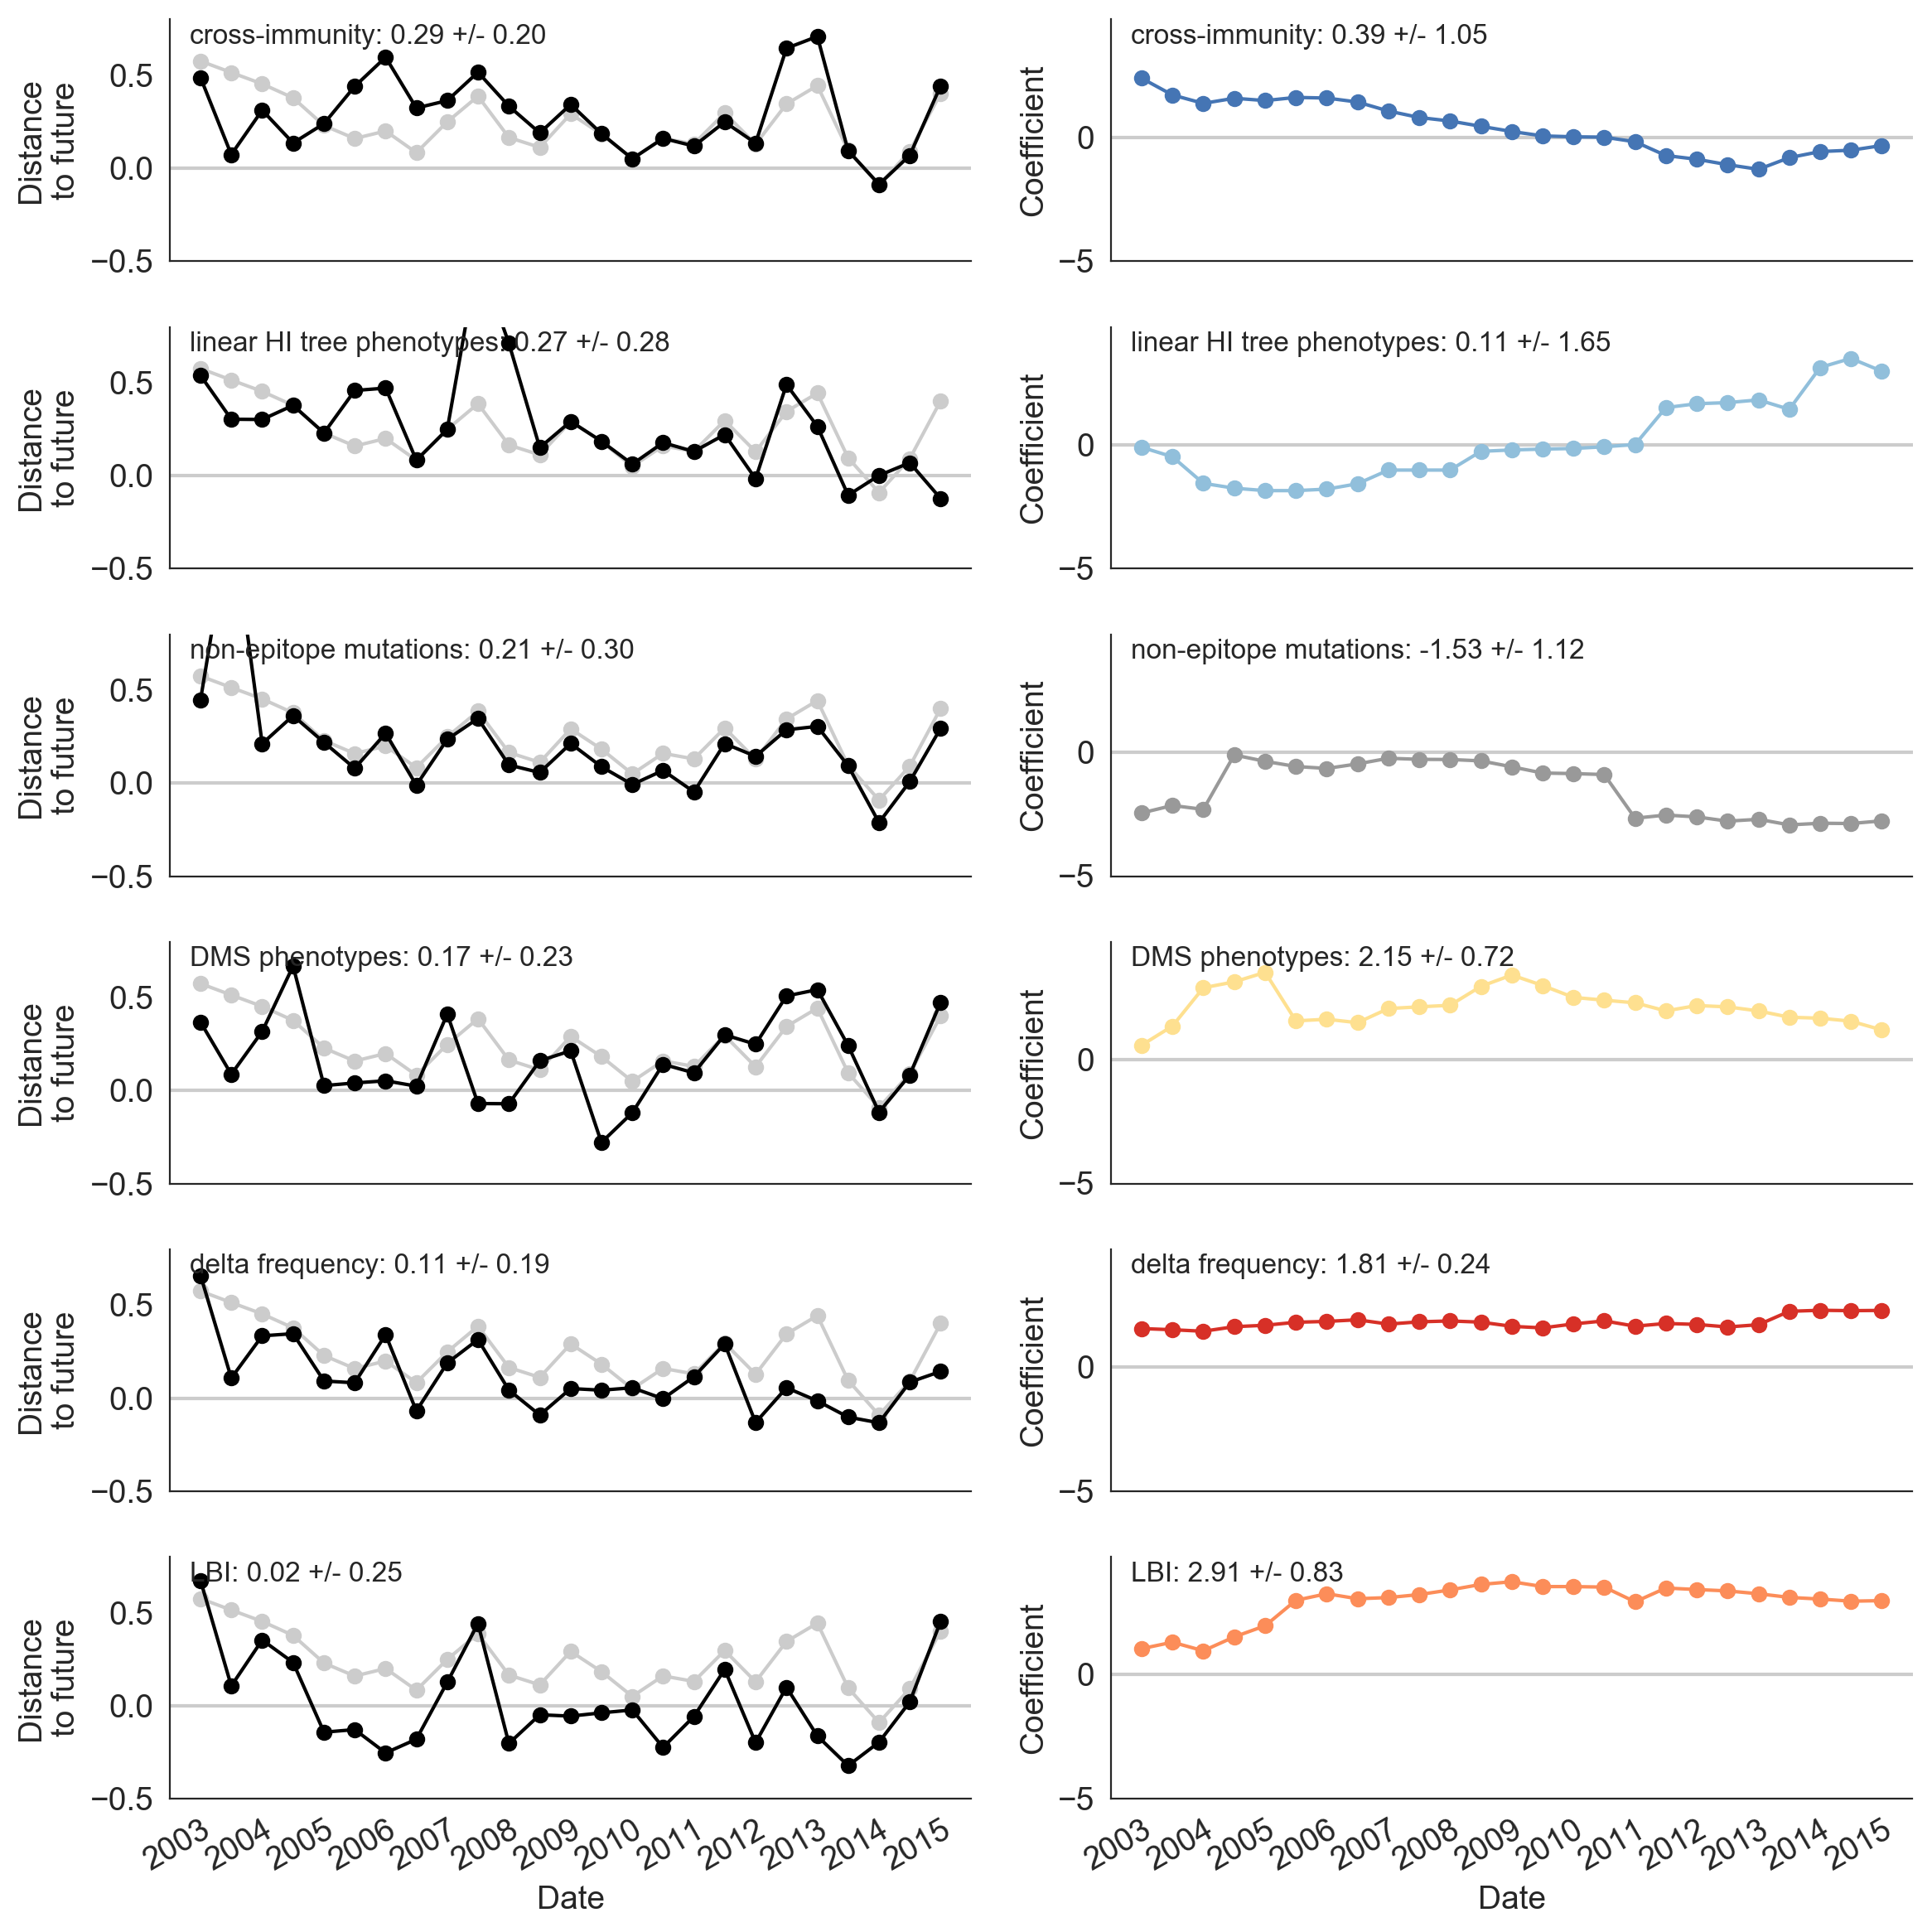

In [57]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(individual_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance\nto future")
    distance_ax.set_ylim(-0.5, 0.8)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 1)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], coefficient_df["coefficient"].mean(), coefficient_df["coefficient"].std()),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    coefficient_ax.plot(
        coefficient_df["validation_timepoint"],
        coefficient_df["coefficient"],
        "o-",
        color=color_by_predictor[predictor]
    )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

# show x-axis tick lines

In [58]:
composite_predictor_names_order = ["lbi", "ep_x", "ne_star"] + [
    predictor
    for predictor in predictor_names_order
    if "-" in predictor
]

In [59]:
nrows_composite = len(composite_predictor_names_order)

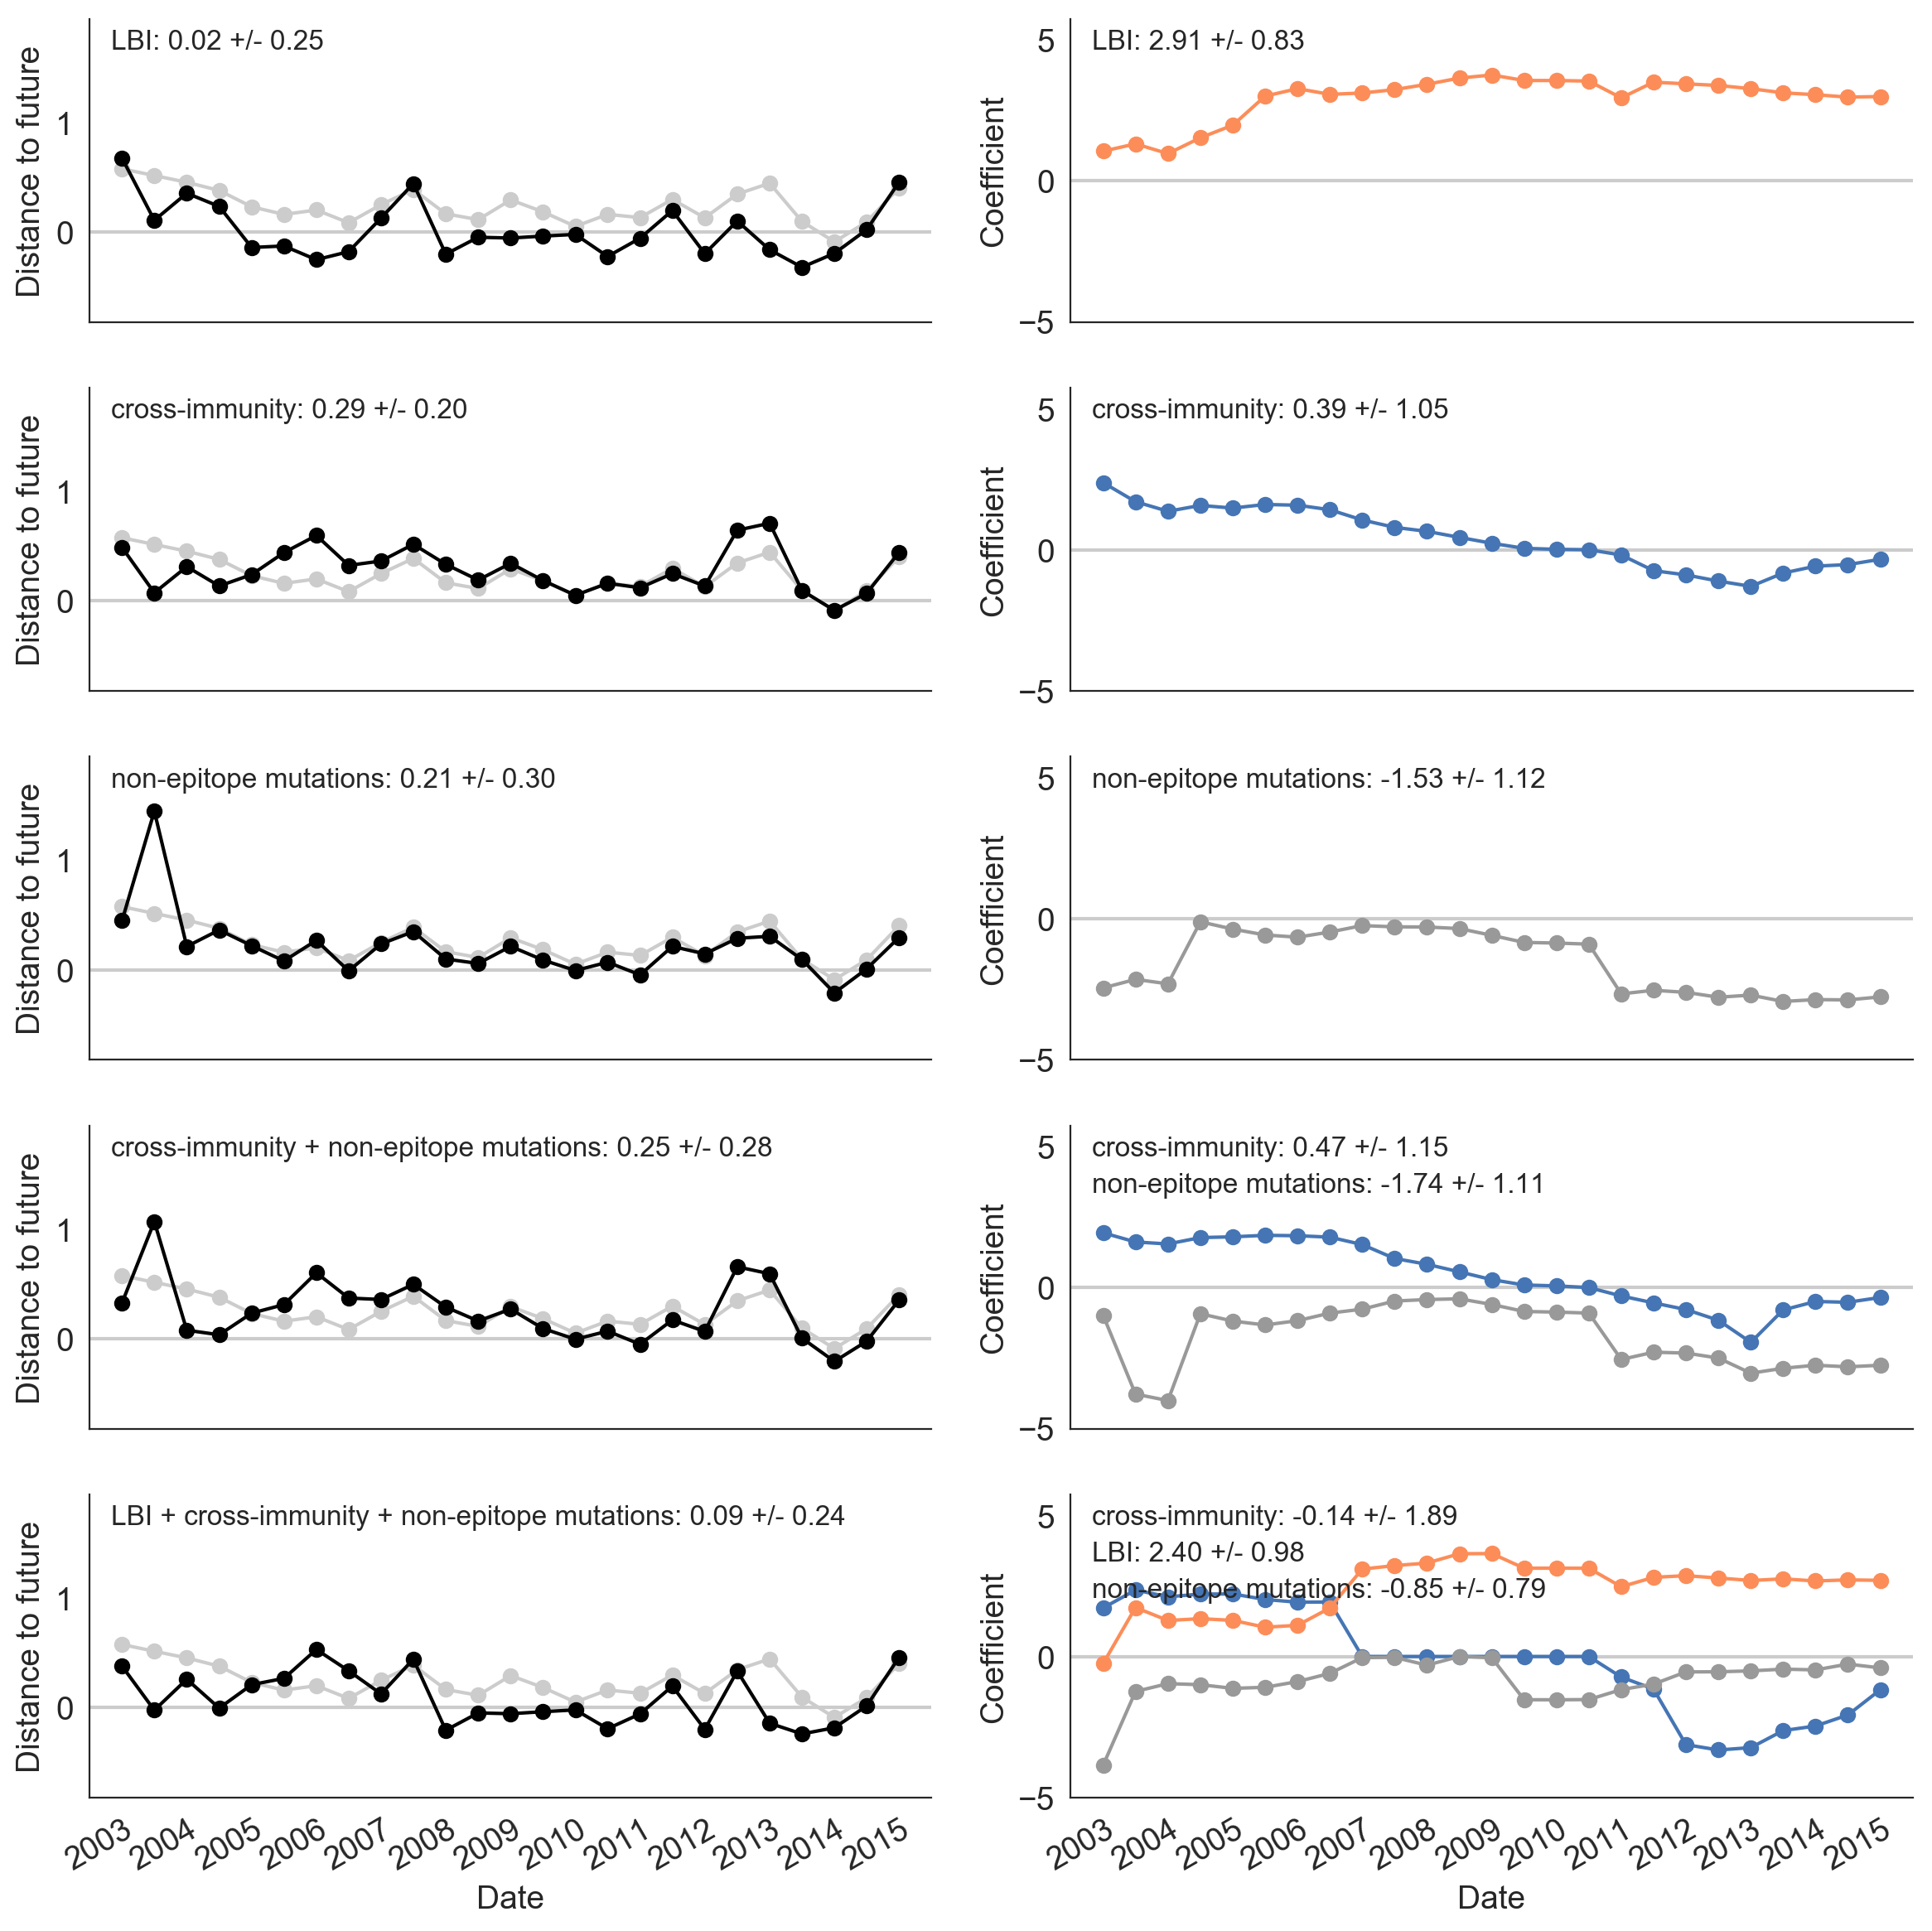

In [60]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows_composite,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

for i, predictor in enumerate(composite_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
    composite_predictors = predictor.split("-")
    composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Distance to future")
    distance_ax.set_ylim(min_normal_error - 0.5, max_normal_error + 0.5)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (composite_predictors_name, error_df["validation_error"].mean(), error_df["validation_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
        naive_error_df["validation_error"],
        "o-",
        color="#cccccc",
        zorder=-10
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["validation_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 2)

    offset = 0.9
    for individual_predictor, individual_predictor_df in coefficient_df.groupby("predictor"):
        coefficient_ax.text(
            0.025,
            offset,
            "%s: %.2f +/- %.2f" % (
                name_by_predictor[individual_predictor],
                individual_predictor_df["coefficient"].mean(),
                individual_predictor_df["coefficient"].std()
            ),
            fontdict={"fontsize": 12},
            transform=coefficient_ax.transAxes
        )
        offset = offset - 0.12
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
        coefficient_ax.plot(
            predictor_coefficient_df["validation_timepoint"],
            predictor_coefficient_df["coefficient"],
            "o-",
            color=color_by_predictor[predictor]
        )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations.png")

# show x-axis tick lines